# Models with Vector Inputs

This is a basic tutorial on supervised models with vector inputs (the input is a vector of aggregated features). 

We approach the problem from the optimization perspective and demonstrate how a series of increasingly complex models can be built using a generic optimizer (stochastic gradient descent (SGD)).

## Data

This notebook uses only generated datasets, there are no external dependencies.

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input, Concatenate, Embedding, Dot

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc, cm
plt.rcParams.update({'pdf.fonttype': 'truetype'})

# Step 1: Linear Regression

We start with building a basic one-dimensional linear regression model using SGD.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
16/16 - 0s - loss: 1.0996 - mse: 1.0996

Test MSE: 1.0996476411819458


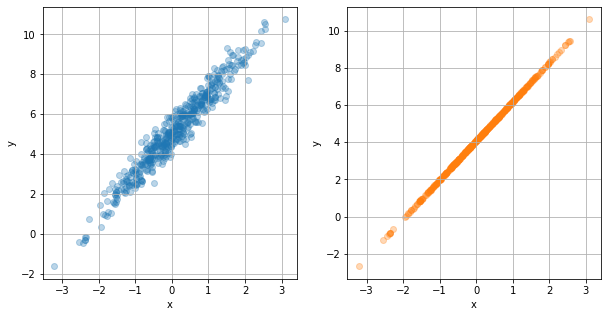

In [2]:
m = 1       # dimensions
n = 500     # samples

x = np.random.randn(n, m)
c = 2 * np.ones(m)
y = np.dot(x, c.T) + 0.5 * np.random.randn(n) + 5

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer = 'rmsprop',
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

model.fit(x, y, epochs=256, verbose=0)

model.summary()

test_loss, test_mse = model.evaluate(x,  y, verbose=2)

print('\nTest MSE:', test_mse)

y_hat = model.predict(x)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x, y, c='C0', alpha=0.3)
ax[1].scatter(x, y_hat, c='C1', alpha=0.3)
for i in (0,1):
    ax[i].grid(True)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')

# Step 2: Classificaion with a Linear Boundary 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


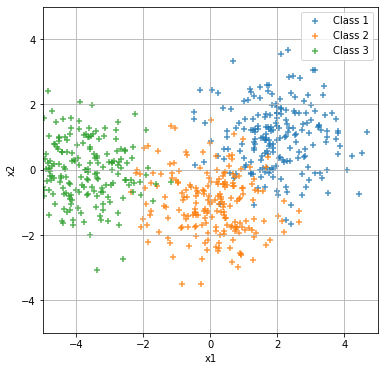

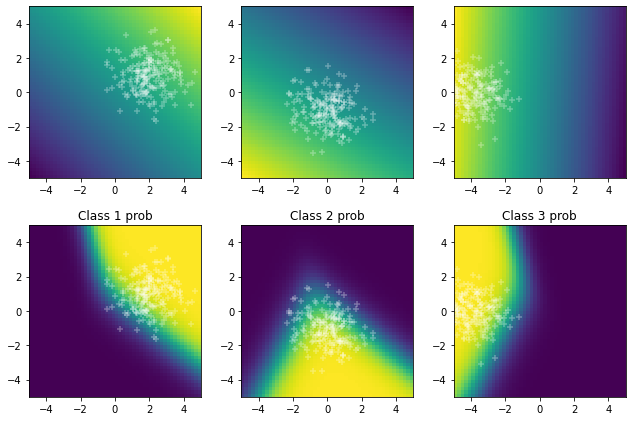

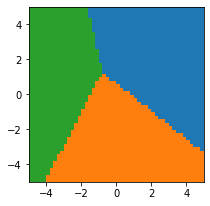

In [3]:
m = 2      # dimensions
n = 200    # samples per class

#
# Input data
#
x1 = np.random.randn(n, m) + np.array((2, 1))
x2 = np.random.randn(n, m) + np.array((0, -1))
x3 = np.random.randn(n, m) + np.array((-4, 0))

#
# Plot input data
#
extent = [-5, 5, -5, 5]
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(x1[:, 0], x1[:, 1], label='Class 1', alpha=0.8, marker='+')
ax.scatter(x2[:, 0], x2[:, 1], label='Class 2', alpha=0.8, marker='+')
ax.scatter(x3[:, 0], x3[:, 1], label='Class 3', alpha=0.8, marker='+')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.grid(True)
ax.legend()

#
# Define and fit the model
#
x = np.vstack([x1, x2, x3])
y = np.hstack([np.zeros(n), np.zeros(n)+1, np.zeros(n)+2]) 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='linear')
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x, y, epochs=150, verbose=0)

model.summary()

#
# Plot class probabilities
#
mesh_steps = 50
x_mesh, y_mesh = np.meshgrid(np.linspace(extent[0], extent[1], mesh_steps), np.linspace(extent[2], extent[3], mesh_steps))
mesh = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

xi = (x1, x2, x3)
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
class_probs = np.zeros([3, mesh_steps, mesh_steps])
for i in range(3):
    class_scores = model.predict(mesh)[:, i].reshape(mesh_steps, mesh_steps)
    ax[0, i].imshow(class_scores, origin='lower', extent=extent, cmap='viridis')
    ax[0, i].scatter(xi[i][:, 0], xi[i][:, 1], alpha=0.3, color='w', marker='+')
    ax[0, i].set_xlim(extent[0], extent[1])
    ax[0, i].set_ylim(extent[2], extent[3])

    class_probs[i] = probability_model.predict(mesh)[:, i].reshape(mesh_steps, mesh_steps)
    ax[1, i].imshow(class_probs[i], origin='lower', extent=extent, cmap='viridis')
    ax[1, i].scatter(xi[i][:, 0], xi[i][:, 1], alpha=0.3, color='w', marker='+')
    ax[1, i].set_xlim(extent[0], extent[1])
    ax[1, i].set_ylim(extent[2], extent[3])
    ax[1, i].set_title(f'Class {i+1} prob')
    
plt.tight_layout()

fig, ax = plt.subplots(1, figsize=(3, 3))
cmap = colors.ListedColormap(['C0', 'C1', 'C2'])
plt.imshow(np.argmax(class_probs, axis=0), origin='lower', extent=extent, cmap=cmap)
plt.tight_layout()

# Step 3: Classification with Nonlinear Boundaries

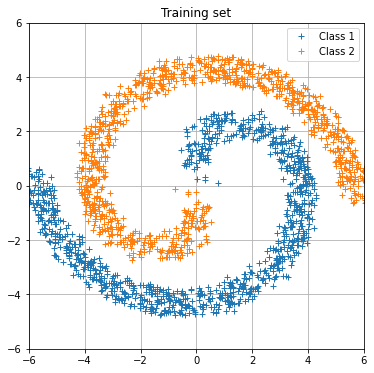

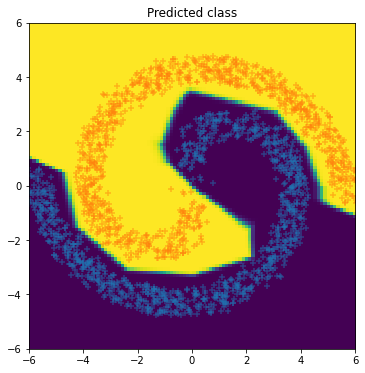

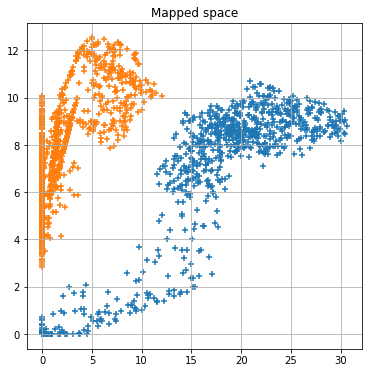

In [14]:
def two_spirals(n_points, noise=1.0):
    n = np.sqrt(np.random.rand(n_points,1)) * 360 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x, d1y)),np.hstack((-d1x, -d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = two_spirals(1000)

extent = [-6, 6, -6, 6]
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Training set')
ax.plot(x[y==0, 0], x[y==0, 1], '+', label='Class 1')
ax.plot(x[y==1, 0], x[y==1, 1], '+', label='Class 2')
ax.legend()
ax.grid(True)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
plt.savefig('nonlinear-dataset.pdf')

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', name='layer_1'),
    tf.keras.layers.Dense(8, activation='relu', name='layer_2'),
    tf.keras.layers.Dense(2, activation='relu', name='layer_3'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output')
])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x, y, epochs=150, batch_size=10,  verbose=0)


mesh_steps = 100
x_mesh, y_mesh = np.meshgrid(np.linspace(extent[0], extent[1], mesh_steps), np.linspace(extent[2], extent[3], mesh_steps))
mesh = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T

prob_mesh = model.predict(mesh).reshape(mesh_steps, mesh_steps)
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Predicted class')
ax.imshow(prob_mesh, origin='lower', extent=extent)
ax.scatter(x[y==0, 0], x[y==0, 1], alpha=0.5, color='C0', marker='+')
ax.scatter(x[y==1, 0], x[y==1, 1], alpha=0.5, color='C1', marker='+')
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
plt.savefig('nonlinear-decision.pdf')

model_map_layer = tf.keras.Model(model.input, model.get_layer('layer_3').output)
x_mapped = model_map_layer.predict(x)
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Mapped space')
ax.scatter(x_mapped[y==0, 0], x_mapped[y==0, 1], marker='+')
ax.scatter(x_mapped[y==1, 0], x_mapped[y==1, 1], marker='+')
ax.grid(True)
plt.savefig('nonlinear-mapping.pdf')

# Step 4: Lookup Embeddings

In this section, we demonstrate how sparse features (high-cardinality categorical or one-hot) can be transformed into dense vectors and then used in regression or classfication models.

For the sake of illustration, we consider the problem of modeling interactions between two entities. Many practical problems can be reduced to this form. For example, one needs to model interactions between users and products in a recommendation engine. 

We start with an interaction matrix that includes scores for pairs of entities, and train a model that predicts unknown scores. Each entity ID is mapped to a low-dimensional embedding using a lookup table.  

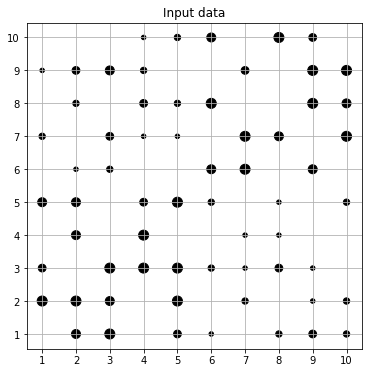

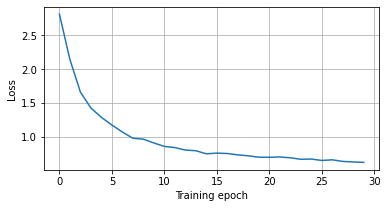

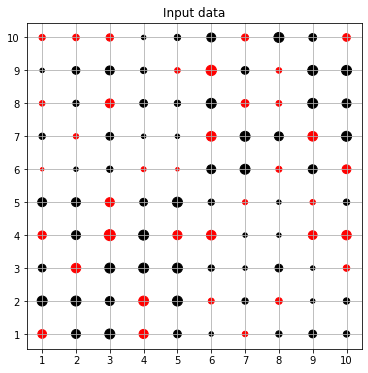

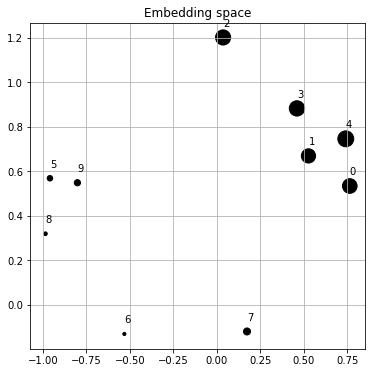

In [111]:
#
# Input data: interaction matrix
#
_ = np.nan
R = [[_, 5, 3, _, 4, _, 2, _, 1, _], #
     [4, 5, _, 4, 4, 1, _, 2, 3, _], # entity A
     [5, 4, 5, _, _, 2, 3, _, 4, _], # group 1
     [_, _, 5, 5, 3, _, 1, 3, 2, 1], #
     [3, 5, 5, _, 5, _, 1, 2, _, 2], # _____________
     [1, _, 2, _, 2, 4, _, 5, _, 4], # 
     [_, 2, 1, 1, _, 5, 5, _, 3, _], # entity A
     [2, _, 3, 1, 1, _, 4, _, _, 5], # group 2
     [3, 1, 1, _, _, 4, _, 5, 5, 3], #
     [2, 2, _, _, 2, _, 5, 4, 5, _]] #
    #|             |              |
    #|  entity B   |   entity B   |  
    #|   group 1   |    group 2   |  

#
# Convert an interaction matrix into an array of samples (a_id, b_id, label)
#
def matrix_to_samples(R):
    x = []
    for u in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[u, j]):
                x.append([u, j, R[u, j]])
    return np.array(x)

R_norm = np.array(R)
xy = matrix_to_samples(R_norm)
x1, x2, y = xy[:, 0].astype(int), xy[:, 1].astype(int), xy[:, 2]

#
# Visualize the input data
#
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Input data')
ax.scatter(xy[:, 0] + 1, xy[:, 1] + 1, s = 20 * xy[:, 2], c='k')
ax.set_yticks(range(1, n_a + 1))
ax.set_xticks(range(1, n_b + 1))
ax.grid(True)

#
# Model specification
#
n_a, n_b = R_norm.shape
embedding_dim = 2

input_a = Input(shape=(1,))
input_b = Input(shape=(1,))

embedding_a = Embedding(input_dim=n_a, output_dim=embedding_dim, name='a_embedding')(input_a)
embedding_b = Embedding(input_dim=n_b, output_dim=embedding_dim, name='b_embedding')(input_b)

combined = Dot(axes=2)([embedding_a, embedding_b])

score = Dense(1, activation='linear')(combined)

model = Model(inputs=[input_a, input_b], outputs=score)

#
# Model training
#
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_absolute_error') 
history = model.fit([x1, x2], y, batch_size=1, epochs=30, verbose=0, validation_data=([x1, x2], y)) 

fix, ax = plt.subplots(1, figsize=(6, 3))
ax.plot(history.history['loss']);
ax.set_xlabel('Training epoch')
ax.set_ylabel('Loss')
ax.grid(True)

#
# Impute and visualize the unknown values 
#
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Input data')
ax.scatter(xy[:, 0] + 1, xy[:, 1] + 1, s = 20 * xy[:, 2], c='k')
ax.set_yticks(range(1, n_a + 1))
ax.set_xticks(range(1, n_b + 1))
ax.grid(True)
imputed_xy = []
for ai in range(n_a):
    for bi in range(n_b):
        if np.isnan(R_norm[ai, bi]):
            score = model.predict([np.array([ai]), np.array([bi])])[0, 0, 0]
            imputed_xy.append([ai, bi, score])
        
imputed_xy = np.array(imputed_xy)
ax.scatter(imputed_xy[:, 0] + 1, imputed_xy[:, 1] + 1, s = 20 * imputed_xy[:, 2], c='r')

#
# Visualize embedding space
#
a_embedding_model = tf.keras.Model(model.input, model.get_layer('a_embedding').output)

a_embeddings = []
scores = []
for ai in range(n_a):
    bi = 1    # any specific entity B
    e = a_embedding_model.predict([np.array([ai]), np.array([bi])])[0, 0]
    score = model.predict([np.array([ai]), np.array([bi])])[0, 0]
    a_embeddings.append(e)
    scores.append(score)
    
a_embeddings = np.array(a_embeddings)
scores = np.array(scores)
fix, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Embedding space')
ax.scatter(a_embeddings[:, 0], a_embeddings[:, 1], s=10*np.power(scores, 2), c='k')
for i in range(n_a):
    ax.annotate(i, (a_embeddings[i, 0], a_embeddings[i, 1]), xytext=(a_embeddings[i, 0], a_embeddings[i, 1] + 0.05))
ax.grid(True)